In [13]:
import tripyview.sub_notebookheader as nb_setup
# which_matplotlib = 'inline' (default), 
#                    'notebook'(jupyter notebook), 
#                    'widget'(jupyterlab)
nb_setup.init_notebook(which_matplotlib="inline")
# centralized autoimport of: 
# import os
# import warnings
# import time as clock
# import numpy as np
# import xarray as xr
# import shapefile as shp
# import tripyview as tpv
# client, use_existing_client = None, "tcp://0.0.0.0:0000"
# use_existing_client='tcp://127.0.0.1:44299'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [14]:
# parameters
#___Dask Client Parameters____________________________________________________________
do_papermill      = False
do_parallel       = True
parallel_nprc     = 64   # number of total processes
parallel_nthread  = 2    # number of threads per worker --> number worker = parallel_nprc/parallel_nthread
parallel_tmem     = 256  # max. available RAM

#___Mesh Path & Save Path_____________________________________________________________
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
# mesh_path         = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
mesh_path         = '/albedo/work/user/pscholz/mesh_fesom2.0/dart/'
# mesh_path         = '/work/ba1264/a270210/model/input/fesom2/dart/'

save_path         = None #'~/figures/test_papermill/'
save_fname        = None # filename from papermill come in through save_fname
tripyrun_name     = None # papermill workflow name of notebook 
tripyrun_analysis = None # papermill diagnostic driver
tripyrun_spath_nb = None # papermill path to processed notebooks
tripyrun_spath_fig= None # papermill path to processed figures

#___Data Path & Input Names___________________________________________________________
input_paths   = list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')
# input_paths.append('/work/ab0995/a270210/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/hist1950d/outdata/fesom/')
input_paths.append('/albedo/work/user/pscholz/results/dart_linfs_pc0_ctrl_1/1/')

input_names   = list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
# input_names.append('TKE')
input_names.append('dart est')

vname     = 'aamoc' # 'gmoc', 'amoc', 'aamoc', 'ipmoc', 'pmoc', 'imoc', shp.Reader(custom_shapefile_path)
# vname     = shp.Reader(os.path.join(os.path.expanduser('~/tripyview/tripyview/shapefiles/moc_basins/'), 'MY_MOC.shp'))

# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl    = None
do_allcycl= False
year      = [1958,1961]
mon       = None
day       = None
record    = None 
box       = None
depth     = None
dlat      = 1.0   # binning resolution in deg 
do_bolus  = False

#___Define Reference Data, Year, Mon ...______________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None # '/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/'
ref_name  = None # 'TKE'
ref_year  = None #[1979, 2019]
ref_mon   = None
ref_day   = None
ref_record= None

#___Define Climatology________________________________________________________________
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'
# clim_path = '/pool/data/AWICM/FESOM2/INITIAL/phc3.0/phc3.0_annual.nc'

#___Define Colormap Parameters________________________________________________________
# papermill doesnt like multi variable alignment in a single line
cstr      = 'blue2red'
cnum      = 15
cref      = 0
crange    = None
cmin      = None
cmax      = None
cfac      = None
climit    = None
chist     = True
ctresh    = 0.995

ref_cstr  = 'wbgyr'
ref_cnum  = 15
ref_cref  = 0
ref_crange= None
ref_cmin  = None
ref_cmax  = None
ref_cfac  = None
ref_climit= None
ref_chist = True
ref_ctresh= 0.995

#___Define Plot Parameters____________________________________________________________
ncol              = 2      # number of pannel columns in figure
nrow              = None
box               = [-180, 180, -90, 90]
do_plt            = 'tcf'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = True   # background contour line (thin)
plt_contf         = True  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = None   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            ='fesom' # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh           = False, 
mesh_opt          = dict({'color':'k', 'linewidth':0.10})
do_enum           = False  # do enumeration of panels
do_reffig         = True   # plot reference fig when doing anomalies 
do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None
save_dpi          = 300
save_fmt          = ['png']

In [15]:
# start parallel dask client if do_parallel=True
client = tpv.shortcut_setup_daskclient(client, 
                                       use_existing_client, 
                                       do_parallel, 
                                       parallel_nprc, 
                                       parallel_tmem, 
                                       threads_per_worker=parallel_nthread)

No existing Dask cluster found at: tcp://0.0.0.0:0000
Dask client already running: <Client: 'tcp://127.0.0.1:40945' processes=32 threads=64, memory=214.58 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: //proxy/39035/status,
Dashboard: //proxy/39035/status,Workers: 32
Total threads: 64,Total memory: 214.58 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40945,Workers: 32
Dashboard: //proxy/39035/status,Total threads: 64
Started: 7 minutes ago,Total memory: 214.58 GiB
Comm: tcp://127.0.0.1:36633,Total threads: 2
Dashboard: //proxy/41225/status,Memory: 6.71 GiB
Nanny: tcp://127.0.0.1:35823,


In [16]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', do_info=True)

#______________________________________________________________________________________________________
# create input_path spinupcycle structure
input_paths, input_names, ref_path, ref_name = tpv.shortcut_setup_pathwithspinupcycles(input_paths, input_names, ref_path, ref_name, n_cycl, do_allcycl)
        
#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path is not None): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record    
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)    

#______________________________________________________________________________________________________    
# concatenate ref_path and input_path together if is not None,  concatenate list = list1+list2
input_paths, input_names = tpv.shortcut_setup_concatinputrefpath(input_paths, input_names, ref_path, ref_name)

# #______________________________________________________________________________________________________
# # define index regions --> reading shape files
# box = tpv.shortcut_setup_boxregion(box_region)


#______________________________________________________________________________________________________
# set predefined chunks size here! The optimized worker memory dependent chunk size is computed internally. 
# see def compute_optimal_chunks(path, client=None, varname=None, opti_dim='h', opti_chunkfrac=0.10):
# The here presetted values are used when tpv.load_data_fesom2( ..., opti_dim=None', ...), otherwise the 
# chunks are choosen to be not larger than 10% of the worker memory tpv.load_data_fesom2( ..., 
# opti_dim='hori', opti_chunkfrax=0.1, ...). Optimized can be the horizontal, vertical or time 
# dimension opti_dim: 'h', 'v', 'hv', 'vh', 't', 'off', None
chunks = dict({
               'elem' : 'auto', 'nod2' : 'auto', 'edg_n': 'auto',
               'nz1'  : 'auto', 'nz'   : 'auto', 
               'time' : 'auto', 
               }) 

 > found *.jlib file: /albedo/work/user/pscholz/mesh_fesom2.0/dart
 > load  *.jlib file: tripyview_mesh_dart_focus0.jlib
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/dart
 > id              = dart
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, True
 > do narea,nresol = True, True
___________________________________________
 > #node           = 3160340
 > #elem           = 6262485
 > #lvls           = 70
___________________________________________


/albedo/work/user/pscholz/results/dart_linfs_pc0_ctrl_1/1/ dart est
 --> elasped time to load w data: 0.03 min.
 --> data uses 1.69 Gb:



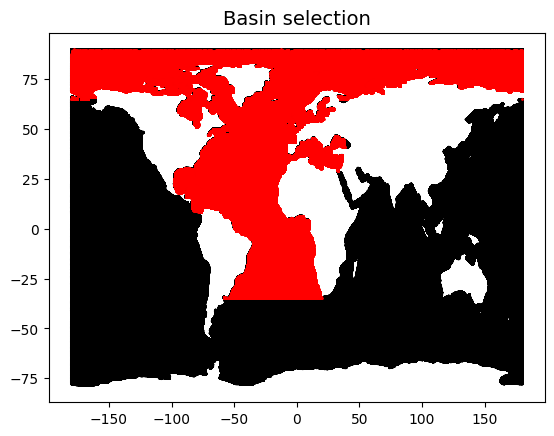

 --> rechunk: 1 -> 64
 --> elasped time to compute moc: 0.62 min.
 --> data uses 0.00 Gb:

 --> total elasped time to process data: 0.66 min.


In [17]:
t0 = clock.time()
# clean up garabage on workers before the party starts!
if client is not None: client.run(gc.collect)
    
aux_vname, aux_vnamebv = 'w', 'bolus_w'
#______________________________________________________________________________________________________    
flag_checkb = True
data_list = list()
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)): 
    print(datapath, descript)
    ts = clock.time()
    
    #____________________________________________________________________________________________________
    # input parameter shortcut
    input_dict = dict({'year':year, 'mon':None, 'descript':descript, 'do_rot':False, 
                       'do_zarithm':None, 'do_ie2n':False, 'do_nan':False, 
                       'chunks':chunks, 'do_load':False, 'do_persist':False, 'do_parallel':do_parallel,
                       'client':client, 'opti_dim':'h' , 'opti_chunkfrac':0.06,
                       'do_info':False,})
        
    #__________________________________________________________________________________________________
    # load data
    data = tpv.load_data_fesom2(mesh, datapath, vname=aux_vname, **input_dict)
    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    
    # load bolus velocities
    if do_bolus: data[aux_vname].data = data[aux_vname].data+tpv.load_data_fesom2(mesh, datapath, vname=aux_vnamebv, **input_dict)[aux_vnamebv].data
    
    print(' --> elasped time to load {:s} data: {:3.2f} min.'.format(aux_vname, (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))
    print('')

    #__________________________________________________________________________________________________        
    # compute zmoc  
    ts = clock.time()
    # zmoc     = tpv.calc_zmoc(mesh, data, dlat=dlonlat, which_moc=vname, do_info=False, do_checkbasin=flag_checkb,
    #                          do_onelem=False, do_load=True, do_parallel=do_parallel, n_workers=parallel_nprc_bin)
    zmoc = tpv.calc_zmoc_dask(mesh, data, do_parallel, parallel_nprc, dlat=dlat, which_moc=vname, do_info=False, 
                              do_checkbasin=flag_checkb)
    print(' --> elasped time to compute moc: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(zmoc.nbytes/(1024**3)))
    print('')
    flag_checkb = False
    del(data)
    
    #__________________________________________________________________________________________________        
    # compute absolute or anomalie    
    if (ref_path is not None): 
        if ii == 0: 
            zmoc_ref = zmoc.copy()
            if do_reffig: data_list.append(zmoc_ref) 
        else:        
            data_list.append( tpv.do_anomaly(zmoc, zmoc_ref) )
    else:                                                   
        data_list.append( zmoc )
    del(zmoc)        
if (ref_path is not None): del(zmoc_ref)    
print(' --> total elasped time to process data: {:3.2f} min.'.format( (clock.time()-t0)/60  ))  

--> histo: cmin, cmax =  -3.032362461090088 18.47597885131836
{'cstr': 'blue2red', 'cnum': 15, 'cref': np.int64(0), 'chist': True, 'ctresh': 0.995, 'cnlab': 8, 'cmin': np.float64(-3.032), 'cmax': np.float64(18.476), 'cmap': <matplotlib.colors.ListedColormap object at 0x154e62b687c0>, 'clevel': array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,
        9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.]), 'clab': array([-3.,  0.,  3.,  6.,  9., 12., 15., 18.])}


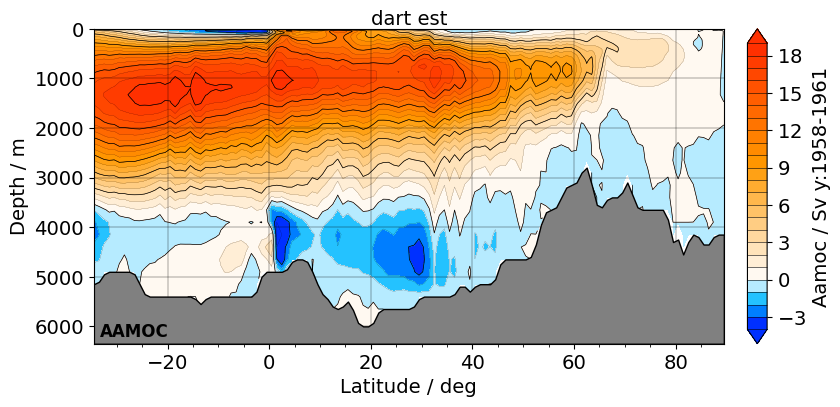

 --> elasped time to plot data: 0.01 min.


In [18]:
#___PLOT ZMOC_______________________________________________________________________________________
ts = clock.time()
ndat = len(data_list)
if   ncol != None: 
    ncol0  = np.min([ncol,ndat])    
    nrow0  = np.ceil(ndat/ncol0).astype('int')
elif nrow != None: 
    nrow0  = np.min([nrow,ndat])    
    ncol0  = np.ceil(ndat/nrow0).astype('int')

svname = list(data_list[0].data_vars)[0]
slabel = data_list[0][svname].attrs['str_lsave']
stname = data_list[0][svname].attrs['short_name'].replace(' ','_').lower()
#__________________________________________________________________________________________________
# do save filename path
spath  = save_path
sfpath = None
if spath!=None: 
    sfpath=list()
    for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, 'zmoc', stname ,slabel, sfmt)) )
if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality
    
#__________________________________________________________________________________________________
# do colorbar either single cbar or ref_cbar + anom_cbar
if (ref_path != None) and do_reffig: cb_plt, cb_plt_single, cinfo0 = [1]+[2]*(nrow0*ncol0-1), False, [ref_cinfo.copy(), cinfo.copy()]
else: cb_plt, cb_plt_single, cinfo0 = True, True, cinfo.copy() 
    
#__________________________________________________________________________________________________    
hfig, hax, hcb = tpv.plot_vslice(mesh, data_list, nrow=nrow0, ncol=ncol0, cinfo=cinfo0, do_rescale=do_rescale, 
                                    do_plt=do_plt, plt_contb=plt_contb, plt_contf=plt_contf, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                    ax_opt=dict({'fig_sizefac':2.0, 'cb_plt':cb_plt, 'cb_plt_single':cb_plt_single, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                    cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(),
                                    do_save=sfpath, save_dpi=save_dpi )  

print(' --> elasped time to plot data: {:3.2f} min.'.format( (clock.time()-ts)/60  )) 

In [19]:
if do_papermill and do_parallel and client is not None: client.shutdown()